In [13]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from source.qBN.qBNMC import qBayesNet
from source.qBN.qBNRejection import qInference
from XPs.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
bntest = gum.fastBN("SPRINKLER<-RAIN->GRASS WET;SPRINKLER->GRASS WET")
bntest.cpt("RAIN")[:] = [0.2, 0.8]
bntest.cpt("SPRINKLER")[:] = [[0.4, 0.6], [0.01, 0.99]]
bntest.cpt("GRASS WET")[:] = [[[0, 1], [0.8, 0.2]], [[0.9, 0.1], [0.99, 0.01]]]

In [15]:
qbntest = qBayesNet(bntest)
qctest = qbntest.buildCircuit()
qctest.draw(output="latex_source")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{0} :  } & \\lstick{{0} :  } & \\qw \\barrier[0em]{2} & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{1.772})} & \\qw \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{2.941})} \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} \\barrier[0em]{2} & \\qw & \\qw & \\ctrl{1} & \\qw \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} \\barrier[0em]{2} & \\qw & \\ctrl{1} \\barrier[0em]{2} & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{1} :  } & \\lstick{{1} :  } & \\gate{\\mathrm{R_Y}\\,(\\mathrm{2.214})} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{-1} & \\gate{\\mathrm{X}} & \\qw & \\ctrl{-1} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}}

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

In [3]:
alarm_bn = gum.loadBN("alarm.dsl")

In [4]:
def getRandomBinaryCPT(num_parents):
    if num_parents <= 0:
        r = random.random()
        return [r, 1-r]
    else:
        return [getRandomBinaryCPT(num_parents-1), getRandomBinaryCPT(num_parents-1)]

def randomChoice(elements, num_choice):
    res = set()
    for i in range(num_choice):
        chosen = random.choice(list(elements))
        elements.discard(chosen)
        res.add(chosen)
    return res

In [5]:
binary_bn = gum.BayesNet('Binary BN')

for n_id in alarm_bn.nodes():
    binary_bn.add(gum.LabelizedVariable(alarm_bn.variable(n_id).name(), alarm_bn.variable(n_id).description(), 2))

for tail, head in alarm_bn.arcs():
    binary_bn.addArc(tail, head)

for n_id in alarm_bn.nodes():
    binary_bn.cpt(n_id)[:] = getRandomBinaryCPT(len(binary_bn.parents(n_id)))

In [6]:
binary_bn.cpt(30)

(pyAgrum.Potential<double>@0x5687d42c8e50) 
                           ||  CATECHOL         |
ARTCO2|SAO2  |TPR   |INSUFF||0        |1        |
------|------|------|------||---------|---------|
0     |0     |0     |0     || 0.8044  | 0.1956  |
1     |0     |0     |0     || 0.5777  | 0.4223  |
0     |1     |0     |0     || 0.6316  | 0.3684  |
1     |1     |0     |0     || 0.3742  | 0.6258  |
0     |0     |1     |0     || 0.2548  | 0.7452  |
1     |0     |1     |0     || 0.6161  | 0.3839  |
[...4 more line(s) ...]
0     |1     |0     |1     || 0.8660  | 0.1340  |
1     |1     |0     |1     || 0.9512  | 0.0488  |
0     |0     |1     |1     || 0.3857  | 0.6143  |
1     |0     |1     |1     || 0.0861  | 0.9139  |
0     |1     |1     |1     || 0.9291  | 0.0709  |
1     |1     |1     |1     || 0.2348  | 0.7652  |

In [30]:
bn0 = gum.fastBN("X1->X2->X3->X4->X5->X6->X7->X8->X9->X10->X11->X12->X13->X14->X15->X16->X17->X18->X19->X20")

In [31]:
bn0.cpt("X1")[:] = [0.01, 0.99]

In [32]:
qbn0 = qBayesNet(bn0)
qc0 = qbn0.buildCircuit()
qinf0 = qInference(qbn0)
qinf0.setEvidence({0:0})
qinf0.setMaxIter(10)
qinf0.getGates()
#qinf0.transpileGates()
#qc0.draw(output="mpl")

#transpile function 
#12 nodes 15s 
#13 nodes 1m12s
#14 nodes 4m57s
#15 nodes 19m33s

In [33]:
from qiskit import QuantumCircuit
A  = QuantumCircuit(*list(qinf0.q_registers.values()))
qinf0.addA(A)

G  = QuantumCircuit(*list(qinf0.q_registers.values()))
qinf0.addG(G, A, {0:0})

In [12]:
print('\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{0} :  } & \\lstick{{0} :  } & \\qw \\barrier[0em]{2} & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{1.772})} & \\qw \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{2.941})} \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} \\barrier[0em]{2} & \\qw & \\qw & \\ctrl{1} & \\qw \\barrier[0em]{2} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} \\barrier[0em]{2} & \\qw & \\ctrl{1} \\barrier[0em]{2} & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{1} :  } & \\lstick{{1} :  } & \\gate{\\mathrm{R_Y}\\,(\\mathrm{2.214})} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{-1} & \\gate{\\mathrm{X}} & \\qw & \\ctrl{-1} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\qw & \\gate{\\mathrm{X}} & \\ctrl{1} & \\gate{\\mathrm{X}} & \\qw & \\qw & \\ctrl{1} & \\qw & \\qw & \\ctrl{1} & \\qw & \\qw & \\meter & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{2} :  } & \\lstick{{2} :  } & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{\\pi})} & \\qw & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{0.9273})} & \\qw & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{0.6435})} & \\qw & \\qw & \\gate{\\mathrm{R_Y}\\,(\\mathrm{0.2003})} & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw\\\\\n\t \t\\nghost{\\mathrm{{meas} :  }} & \\lstick{\\mathrm{{meas} :  }} & \\lstick{/_{_{3}}} \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\cw & \\dstick{_{_{\\hspace{0.0em}0}}} \\cw \\ar @{<=} [-3,0] & \\dstick{_{_{\\hspace{0.0em}1}}} \\cw \\ar @{<=} [-2,0] & \\dstick{_{_{\\hspace{0.0em}2}}} \\cw \\ar @{<=} [-1,0] & \\cw & \\cw\\\\\n\\\\ }}\n\\end{document}')

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{0} :  } & \lstick{{0} :  } & \qw \barrier[0em]{2} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.772})} & \qw \barrier[0em]{2} & \qw & \gate{\mathrm{R_Y}\,(\mathrm{2.941})} \barrier[0em]{2} & \qw & \gate{\mathrm{X}} & \ctrl{1} & \gate{\mathrm{X}} \barrier[0em]{2} & \qw & \qw & \ctrl{1} & \qw \barrier[0em]{2} & \qw & \gate{\mathrm{X}} & \ctrl{1} & \gate{\mathrm{X}} \barrier[0em]{2} & \qw & \ctrl{1} \barrier[0em]{2} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{1} :  } & \lstick{{1} :  } & \gate{\mathrm{R_Y}\,(\mathrm{2.214})} & \qw & \gate{\mathrm{X}} & \ctrl{-1} & \gate{\mathrm{X}} & \qw & \ctrl{-1} & \qw & \gate{\mathrm{X}} & \ctrl{1} & \gate{\mathrm{X}} & \qw & \gate{\mathrm{X}} & \ctrl{1} & \gate{\mathrm{X}} & \qw & \qw & \ctrl{1} & \qw & \qw & \ctrl{1} & \qw & \qw & \meter & \qw & \qw & \qw\\
	 	\ngho

In [35]:
qinf0.makeInference(verbose=1)
#inference simulation time 10 iter, 07890

#12 nodes 7s
#13 nodes 12s
#14 nodes 14s
#15 nodes 16m16s


AerError: 'unknown instruction: cry'

In [18]:
qinf0.log

{'A': 21, 'G': 515}

In [9]:
print(qinf0.log)
qrt0 = qRuntime(qinf0, backend)
qrt0.rejectionSamplingRuntime()

{'A': 185, 'G': 271}


0.4161590600000001

In [ ]:
qbn = qBayesNet(binary_bn)
qc = qbn.buildCircuit(add_measure=True)

In [148]:
num_runs = 1
num_evidence_var = 10
max_iter = 2000

for i in range(num_runs):

    #Randomly Chosen Evidence and Target
    n_ids = binary_bn.nodes()
    evidence = {ev_id: random.randint(0,1) for ev_id in randomChoice(n_ids, num_evidence_var)}
    target = randomChoice(n_ids, 1)

    #Lazy Propagation Benchmark
    ie = gum.LazyPropagation(binary_bn)
    ie.setEvidence(evidence)
    ie.makeInference()
    print(f"Evidence: {evidence}, Target: {target}")
    print(f"Evidence probability ({num_evidence_var} values): {ie.evidenceProbability()}")

    #Quantum Rejection Sampling
    qinf = qInference(qbn)
    qrt = qRuntime(qinf, backend)
    qinf.setEvidence(evidence)
    qinf.setMaxIter(max_iter)
    qinf.makeInference()
    qinf_run_time = qrt.rejectionSamplingRuntime()
    qinf_max_error = (qinf.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"QS - Run time: {qinf_run_time}, Max Error: {qinf_max_error}")

    #Monte Carlo Classical Rejection Sampling
    mc = gum.MonteCarloSampling(binary_bn)
    mc.setEpsilon(1e-20)
    mc.setMaxTime(1e20)
    mc.setEvidence(evidence)
    mc.setMaxIter(max_iter)
    mc.makeInference()
    mc_run_time = mc.currentTime()
    mc_max_error = (mc.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"MC - Run time: {mc_run_time}, Max Error: {mc_max_error}")


Evidence: {1: 1, 3: 0, 5: 1, 8: 0, 14: 0, 15: 0, 20: 0, 23: 1, 24: 1, 31: 0}, Target: {12}
Evidence probability (10 values): 6.952018710175363e-05


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [111]:
evidence = {"MINVOLSET": 0, "DISCONNECT": 0}
ie = gum.LazyPropagation(binary_bn)
ie.setEvidence(evidence)
ie.makeInference()
print(f"Evidence: {evidence}")
print(f"Evidence probability: {ie.evidenceProbability()}")

Evidence: {'MINVOLSET': 0, 'DISCONNECT': 0}
Evidence probability: 0.05825177497125137


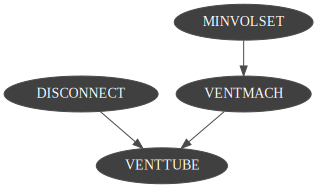

In [8]:
qinf = qInference(qbn)
qinf.setEvidence(evidence)
qinf.setMaxIter(1000)
qinf.useFragmentBN(target={target_node})
gnb.showBN(qinf.qbn.bn, size=20)

In [9]:
qinf.getGates()

In [10]:
qinf.makeInference()

{'VENTMACH': [0.06100000000000005, 0.9240000000000007, 0.007, 0.008],
 'DISCONNECT': [1.0000000000000007, 0],
 'MINVOLSET': [1.0000000000000007, 0, 0],
 'VENTTUBE': [0.9670000000000007,
  0.006,
  0.016000000000000007,
  0.011000000000000003]}

In [11]:
gnb.sideBySide(qinf.posterior(target_node),
               ie.posterior(target_node),
               captions=["qInference", "LazyPropagation"])

In [15]:
mc = gum.MonteCarloSampling(bn)
mc.setEvidence(evidence)
mc.setMaxIter(10000)
mc.makeInference()

In [30]:
r = mc.posterior(target_node).toarray() - ie.posterior(target_node).toarray()

In [32]:
r.max()

0.003758412832682745

In [17]:
bn = gum.fastBN("A->B")
qbn = qBayesNet(bn)
qinf = qInference(qbn)
qinf.setEvidence({0:0})

In [18]:
qinf.getGates()

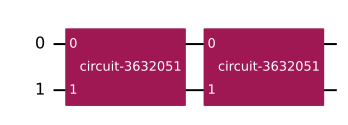

In [23]:
qinf.G.power(2).draw(output="mpl")

In [17]:
mc.messageApproximationScheme()

'stopped with max iteration=10000'